# Phase 4: Clustering Evaluation & Analysis

In this notebook, we evaluate the quality of the clusters generated in the previous phase.
We load the saved results and perform the following analyses as requested:
1.  **Silhouette Score:** Measuring how similar an object is to its own cluster compared to other clusters.
2.  **Cluster Purity & Composition:** Analyzing how well the clusters map to the true language labels.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use('ggplot')


We load the feature matrix (`X.npy`) and the clustering results (`clustering_results.csv`, `y_kmeans.npy`, `y_agg.npy`) saved in the previous step.
We also re-apply the Scaling and PCA transformation to `X` to ensure we calculate the Silhouette Score in the same feature space used for clustering.


In [4]:
artifacts_dir = Path("artifacts")

X = np.load(artifacts_dir / "X.npy")
results_df = pd.read_csv(artifacts_dir / "clustering_results.csv")
y_kmeans = np.load(artifacts_dir / "y_kmeans.npy")
y_agg = np.load(artifacts_dir / "y_agg.npy")
y_true = results_df['language'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Data Loaded:")
print(f"X_pca shape: {X_pca.shape}")
print(f"Labels shape: {y_kmeans.shape}")


Data Loaded:
X_pca shape: (720, 157)
Labels shape: (720,)


## (b) Clustering Evaluation

### 1. Silhouette Score
The Silhouette Score ranges from -1 to 1. A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.


In [5]:
sil_kmeans = silhouette_score(X_pca, y_kmeans)
sil_agg = silhouette_score(X_pca, y_agg)

print(f"Silhouette Score (K-Means, k=4): {sil_kmeans:.4f}")
print(f"Silhouette Score (Agglomerative, k=4): {sil_agg:.4f}")


Silhouette Score (K-Means, k=4): 0.1655
Silhouette Score (Agglomerative, k=4): 0.1687


### 2. Cluster Purity and Composition Analysis

**Cluster Purity** is an external evaluation metric. To calculate purity, each cluster is assigned to the most frequent class in that cluster, and then the accuracy of this assignment is measured by counting the number of correctly assigned documents and dividing by $N$.

We will also visualize the **Confusion Matrix (Crosstab)** to see exactly which languages ended up in which cluster.


In [8]:
from sklearn.metrics.cluster import contingency_matrix

def purity_score(y_true, y_pred):
    # contingency_matrix strictly computes the intersection of labels
    # and works even if one input is string (Languages) and other is int (Clusters)
    cm = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

purity_k = purity_score(y_true, y_kmeans)
purity_a = purity_score(y_true, y_agg)

print(f"Cluster Purity (K-Means): {purity_k:.4f}")
print(f"Cluster Purity (Agglomerative): {purity_a:.4f}")


Cluster Purity (K-Means): 0.5583
Cluster Purity (Agglomerative): 0.6111


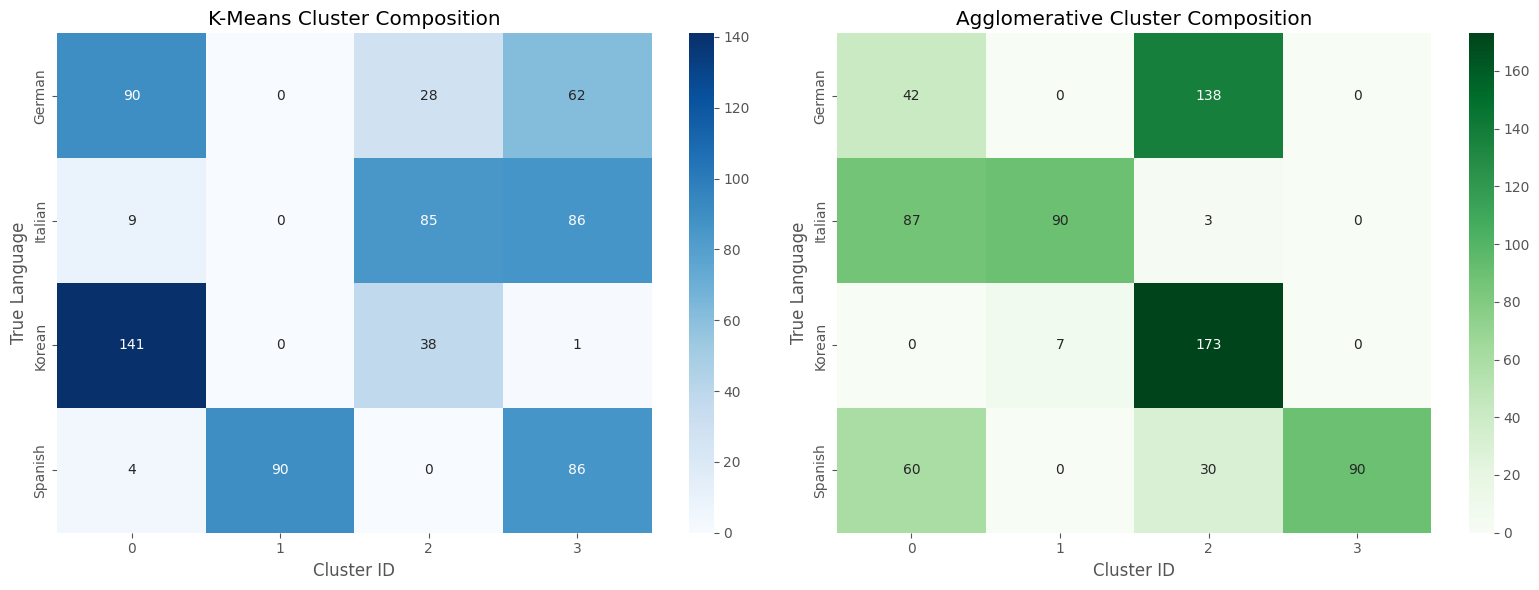

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ct_kmeans = pd.crosstab(results_df['language'], results_df['cluster_kmeans'])
sns.heatmap(ct_kmeans, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('K-Means Cluster Composition')
axes[0].set_ylabel('True Language')
axes[0].set_xlabel('Cluster ID')

ct_agg = pd.crosstab(results_df['language'], results_df['cluster_agg'])
sns.heatmap(ct_agg, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Agglomerative Cluster Composition')
axes[1].set_ylabel('True Language')
axes[1].set_xlabel('Cluster ID')

plt.tight_layout()
plt.show()
